In [4]:
!pip install dabl

     |████████████████████████████████| 559 kB 8.2 MB/s eta 0:00:01
  Created wheel for dabl: filename=dabl-0.1.8-py3-none-any.whl size=565074 sha256=2b2892a5932da53f2941779293cdf0653013aa98b4fc83a052cc5455d7f14217
  Stored in directory: /root/.cache/pip/wheels/76/ab/fe/ba8715c1dbee08327ef56259f0f774fff9c6f84a112f329280
Successfully built dabl
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [23]:
import pandas as pd
import dabl
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

In [8]:
# load data
train = pd.read_csv("/kaggle/input/titanic/train.csv")
pred = pd.read_csv("/kaggle/input/titanic/test.csv")

train_count = len(train)
print("Train Samples : ",len(train))
print("Evaluation Samples :", len(pred))

Train Samples :  891
Evaluation Samples : 418


In [9]:
# drop cabin and ticket
train = train.drop(["PassengerId", "Cabin", "Ticket"], axis=1)
pred_id = pred["PassengerId"]
pred = pred.drop(["PassengerId", "Cabin", "Ticket"], axis=1)

# combine train and pred for feature engineering 
df = pd.concat([train, pred]).reset_index(drop=True)
print("Total Samples :", len(df))
df.head()

Total Samples : 1309


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [10]:
# analyze feature types
types = dabl.detect_types(df)

continuous_features = types[types["continuous"]].index.values.tolist()
categorical_features = types[types["categorical"]].index.values.tolist()
low_card_features = types[types["low_card_int"]].index.values.tolist()
types

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
Survived,False,False,False,True,False,False,False
Pclass,False,False,False,True,False,False,False
Name,False,False,False,False,False,True,False
Sex,False,False,False,True,False,False,False
Age,True,False,False,False,False,False,False
SibSp,False,False,True,False,False,False,False
Parch,False,False,True,False,False,False,False
Fare,True,False,False,False,False,False,False
Embarked,False,False,False,True,False,False,False


In [11]:
# move low cardinality features - SibSp and Parch to continuous features
continuous_features += low_card_features
print("Continuous Features :", continuous_features)
print("Categorical Features :", categorical_features)

Continuous Features : ['Age', 'Fare', 'SibSp', 'Parch']
Categorical Features : ['Survived', 'Pclass', 'Sex', 'Embarked']


In [12]:
# remove outlier using interquartile range
outlier_indices = []

for feature in continuous_features:
    # 1st & 3rd quartile and IQR range
    Q1, Q3 = np.percentile(df[feature], [25, 75])
    IQR = Q3 - Q1

    # finding index of outliers
    outlier_step = 1.5 * IQR
    outlier_list_col = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step )].index
    outlier_indices.extend(outlier_list_col)

# observations with more than 2 outliersR
outlier_indices = Counter(outlier_indices)
multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
print("Outliers : ", len(multiple_outliers))

# drop outliers
df = df.drop(multiple_outliers, axis=0).reset_index(drop=True)

Outliers :  0


In [13]:
# fill missing data
print(df.isnull().sum())

# fill age by median age grouped over Pclass & Sex
df['Age'] = df.groupby(
    ['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

# fill embarked with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# fill fare by median fare grouped over class
df['Fare'] = df.groupby(
    ['Pclass', 'Embarked'])['Fare'].apply(lambda x: x.fillna(x.median()))
df.isnull().sum()

Survived    418
Pclass        0
Name          0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64


Survived    418
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

array([ 0.17, 22.  , 26.  , 36.  ])

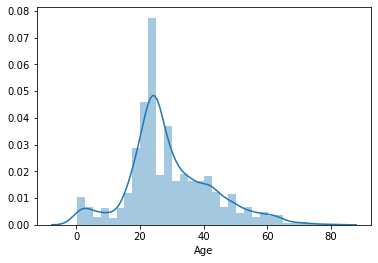

In [14]:
sns.distplot(df["Age"])
np.quantile(df["Age"], [0, .25, .50, .75])

array([ 0.    ,  7.8958, 14.4542, 31.275 ])

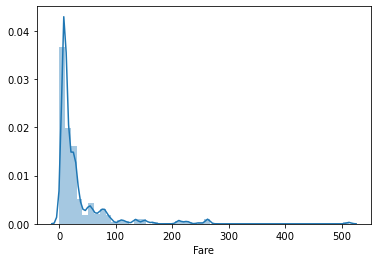

In [15]:
sns.distplot(df["Fare"])
np.quantile(df["Fare"], [0, .25, .50, .75])

In [16]:
# Feature Engineering
# Adding Title Column
title_dictionary = {
    'Capt': 'Dr/Clergy/Mil', 'Col': 'Dr/Clergy/Mil', 'Major': 'Dr/Clergy/Mil',
    'Jonkheer': 'Honorific', 'Don': 'Honorific', 'Dona': 'Honorific', 
    'Sir': 'Honorific', 'Dr': 'Dr/Clergy/Mil', 'Rev': 'Dr/Clergy/Mil',
    'the Countess': 'Honorific', 'Mme': 'Mrs', 'Mlle': 'Miss',
    'Ms': 'Mrs', 'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss',
    'Master': 'Master', 'Lady': 'Honorific'
}

# Extract and Map
df['Title'] = df['Name'].map(
    lambda name: name.split(',')[1].split('.')[0].strip())
df['Title'] = df['Title'].map(title_dictionary)


# Adding Age Bins
names = ['<5', '5-18', '18-35', '35-65', '>65']
df['AgeBin'] = pd.qcut(df['Age'], q=5, labels=names)

# Adding Fare Bins
bins = np.quantile(df["Fare"], [0, .25, .50, .75]).tolist()
bins.append(200)
names = ["fare_00", "fare_25", "fare_50", "fare_75"]
df['FareBin'] = pd.cut(df['Fare'], bins,
                             labels=names)

# Adding Alone & Family Size Column
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
df['Alone'] = df['FamilySize'].map(lambda s: "alone" if s == 1 else "not alone")

df.head(20)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBin,FareBin,FamilySize,Alone
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,5-18,fare_00,2,not alone
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,35-65,fare_75,2,not alone
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,18-35,fare_25,1,alone
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,35-65,fare_75,2,not alone
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,35-65,fare_25,1,alone
5,0.0,3,"Moran, Mr. James",male,25.0,0,0,8.4583,Q,Mr,5-18,fare_25,1,alone
6,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S,Mr,>65,fare_75,1,alone
7,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S,Master,<5,fare_50,5,not alone
8,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S,Mrs,18-35,fare_25,3,not alone
9,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C,Mrs,<5,fare_50,2,not alone


In [17]:
# drop unnecessary columns
survived = df["Survived"]
df = df.drop(["Survived", "Name", "Age", "SibSp", "Parch", "Fare"], axis=1)
# df = df.drop(["Survived", "Name", "SibSp", "Parch"], axis=1)
df.head(10)

,Pclass,Sex,Embarked,Title,AgeBin,FareBin,FamilySize,Alone
0,3,male,S,Mr,5-18,fare_00,2,not alone
1,1,female,C,Mrs,35-65,fare_75,2,not alone
2,3,female,S,Miss,18-35,fare_25,1,alone
3,1,female,S,Mrs,35-65,fare_75,2,not alone
4,3,male,S,Mr,35-65,fare_25,1,alone
5,3,male,Q,Mr,5-18,fare_25,1,alone
6,1,male,S,Mr,>65,fare_75,1,alone
7,3,male,S,Master,<5,fare_50,5,not alone
8,3,female,S,Mrs,18-35,fare_25,3,not alone
9,2,female,C,Mrs,<5,fare_50,2,not alone


In [18]:
# analyze feature types
types = dabl.detect_types(df)

continuous_features = types[types["continuous"]].index.values.tolist()
categorical_features = types[types["categorical"]].index.values.tolist()
low_card_features = types[types["low_card_int"]].index.values.tolist()
continuous_features += low_card_features
types

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
Pclass,False,False,False,True,False,False,False
Sex,False,False,False,True,False,False,False
Embarked,False,False,False,True,False,False,False
Title,False,False,False,True,False,False,False
AgeBin,False,False,False,True,False,False,False
FareBin,False,False,False,True,False,False,False
FamilySize,False,False,True,False,False,False,False
Alone,False,False,False,True,False,False,False


In [19]:
# one hot encoding
df = pd.get_dummies(df, columns=categorical_features, prefix=categorical_features)

In [20]:
# final shapes

# final train test and pred set
X = df.iloc[:train_count]
y = survived.iloc[:train_count]
X_pred = df.iloc[train_count:]

print("Final Data")
print("X:", X.shape, " y:", y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=69)
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_test:", X_train.shape, " y_test:", y_train.shape)
print("X_pred:", X_pred.shape)

Final Data
X: (891, 26)  y: (891,)
X_train: (579, 26)  y_train: (579,)
X_test: (579, 26)  y_test: (579,)
X_pred: (418, 26)


In [31]:
# network
model = Sequential()

model.add(Dense(256, activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               6912      
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

Train on 579 samples, validate on 312 samples
Epoch 1/50
579/579 [==============================] - 0s 624us/step - loss: 0.6741 - accuracy: 0.5976 - val_loss: 0.6548 - val_accuracy: 0.7051
Epoch 2/50
579/579 [==============================] - 0s 90us/step - loss: 0.6579 - accuracy: 0.6149 - val_loss: 0.6343 - val_accuracy: 0.7051
Epoch 3/50
579/579 [==============================] - 0s 89us/step - loss: 0.6409 - accuracy: 0.6528 - val_loss: 0.6126 - val_accuracy: 0.7179
Epoch 4/50
579/579 [==============================] - 0s 88us/step - loss: 0.6208 - accuracy: 0.6805 - val_loss: 0.5894 - val_accuracy: 0.7372
Epoch 5/50
579/579 [==============================] - 0s 92us/step - loss: 0.6099 - accuracy: 0.6857 - val_loss: 0.5656 - val_accuracy: 0.7564
Epoch 6/50
579/579 [==============================] - 0s 91us/step - loss: 0.5813 - accuracy: 0.6943 - val_loss: 0.5416 - val_accuracy: 0.7596
Epoch 7/50
579/579 [==============================] - 0s 90us/step - loss: 0.5760 - accuracy: 0

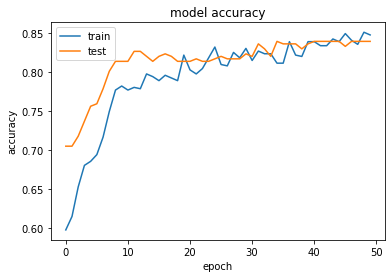

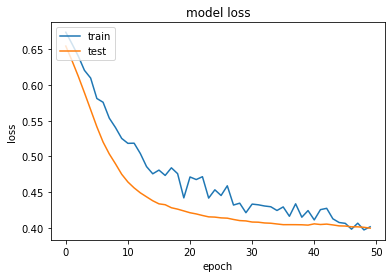

In [32]:
# training with low learning rate and high epochs
model.compile(
    optimizer=Adam(lr=0.00015),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    X_train, y_train, 
    epochs=50,
    validation_data=(X_test, y_test)
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# predict for submission

pred_survived = model.predict(X_pred)
pred_survived = np.rint(pred_survived).reshape((-1)).astype(int)

# create csv
submission = pd.DataFrame(zip(pred_id, pred_survived), columns=['PassengerId', 'Survived'])
submission.to_csv('submission.csv', index=False)
submission.head(20)